# Motor testing with the ODrive

In [55]:
import odrive.core
import matplotlib.pyplot as plt
import numpy as np
import time
import math

%matplotlib qt5


In [83]:
encoder_resolution = 2048

## Connect to Odrive

In [ ]:
my_drive = odrive.core.find_any(consider_usb=True, consider_serial=False, printer=print)
m1 = my_drive.motor1

## Communication latency

First test communication latency when Odrive is not doing motor commutation, or taking control commands.

Mean transfer rate: 3688.570062 Hz
Stddev transfer rate: 398.559163 Hz


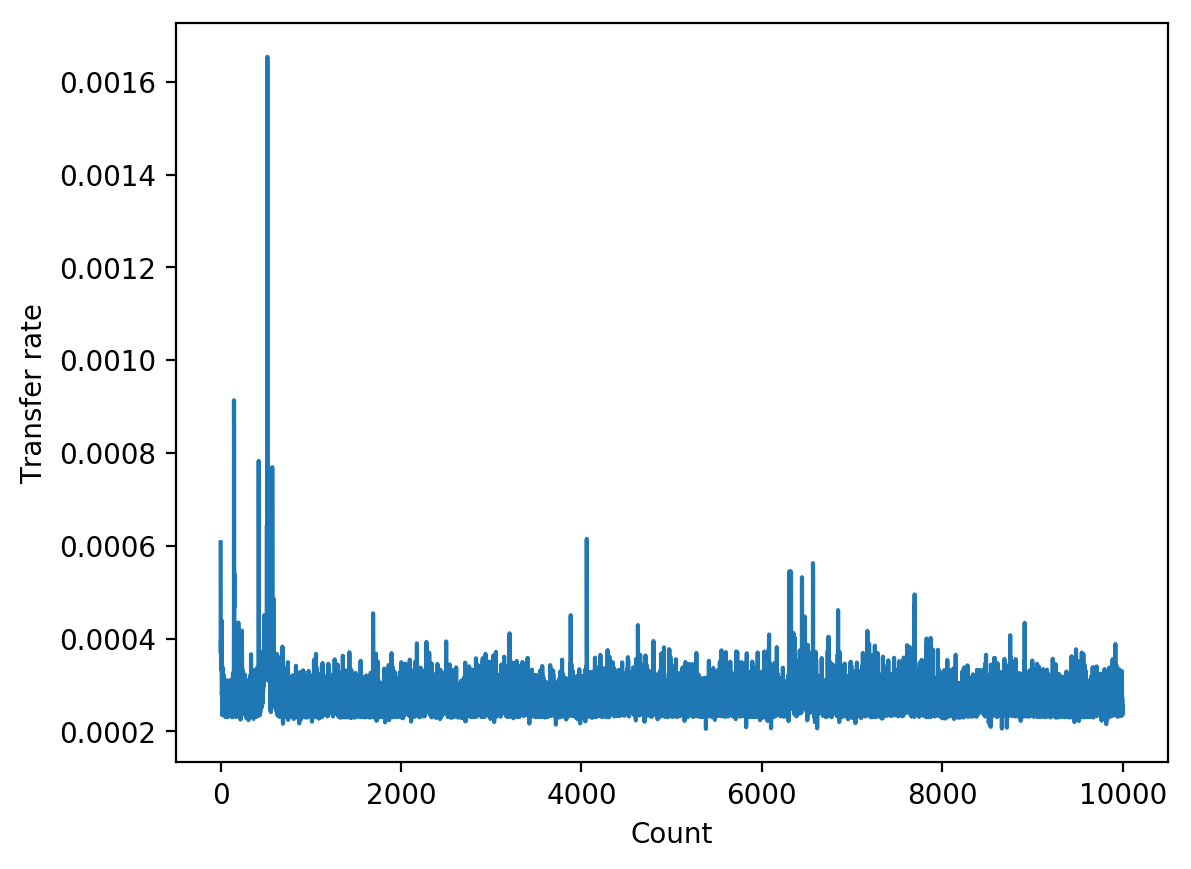

In [68]:
data = {'time': np.zeros((10000,1)), 'pos': np.zeros((10000,1))}

for kk in range(0,10000):
    
    data['time'][kk] = time.monotonic()
    data['pos'][kk] = m1.encoder.pll_pos

plt.clf()
plt.plot(np.diff(data['time'],1,0))
plt.xlabel('Count')
plt.ylabel('Transfer rate')
plt.gcf()

print('Mean transfer rate: %f Hz' % np.mean(1/np.diff(data['time'],1,0)))
print('Stddev transfer rate: %f Hz' % np.std(1/np.diff(data['time'],1,0)))

plt.gcf()

Now set a velocity command and test communication rate

Recovered from USB halt/stall condition on read
Mean transfer rate: 3768.232073 Hz
Stddev transfer rate: 360.450599 Hz


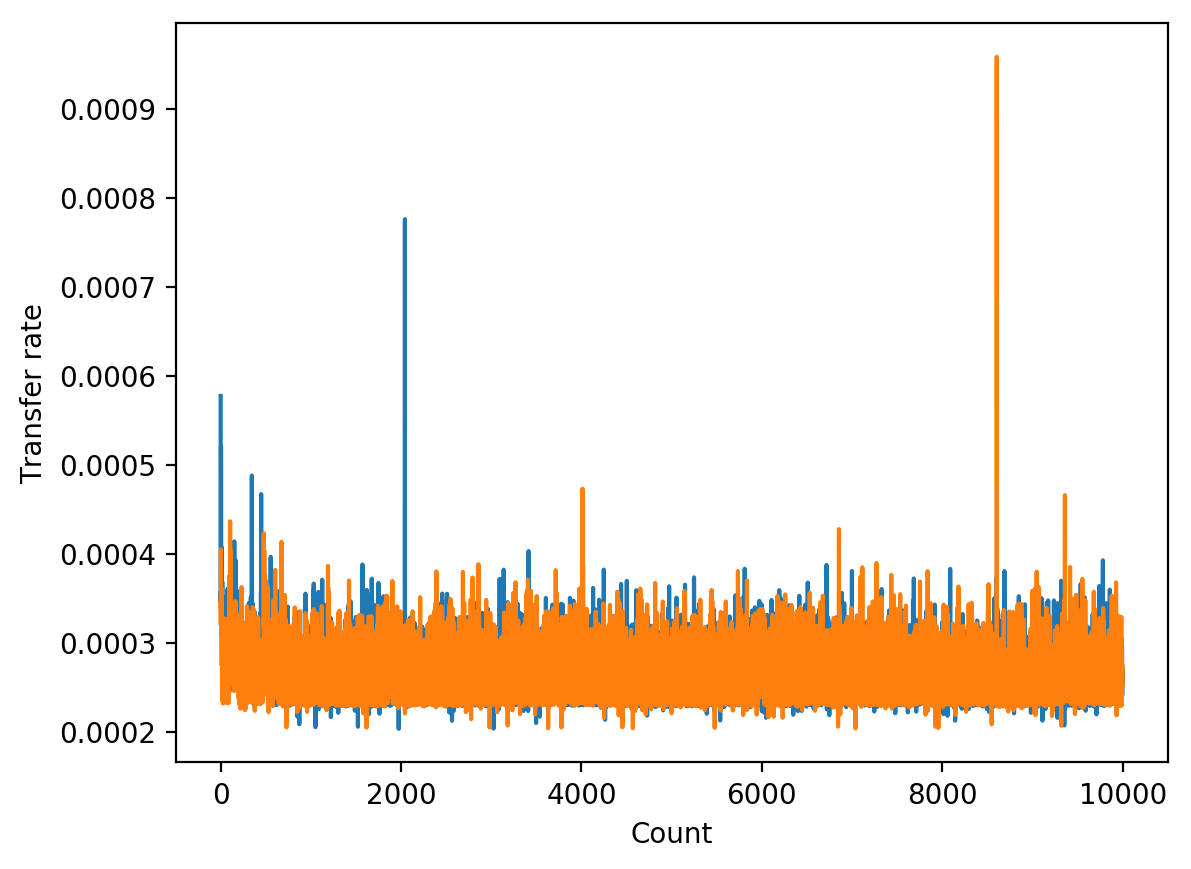

In [52]:
data = {'time': np.zeros((10000,1)), 'pos': np.zeros((10000,1))}

my_drive.motor1.set_vel_setpoint(200000.,0.)
for kk in range(0,10000):
    
    data['time'][kk] = time.monotonic()
    data['pos'][kk] = m1.encoder.pll_pos

# stop and set position to hold at current pos
my_drive.motor1.set_vel_setpoint(0,0.)
my_drive.motor1.set_pos_setpoint(my_drive.motor1.encoder.pll_pos,0., 0.)

plt.plot(np.diff(data['time'],1,0))

print('Mean transfer rate: %f Hz' % np.mean(1/np.diff(data['time'],1,0)))
print('Stddev transfer rate: %f Hz' % np.std(1/np.diff(data['time'],1,0)))

plt.gcf()

Now stream motor move commands

Mean transfer rate: 753.323261 Hz
Stddev transfer rate: 37.471175 Hz


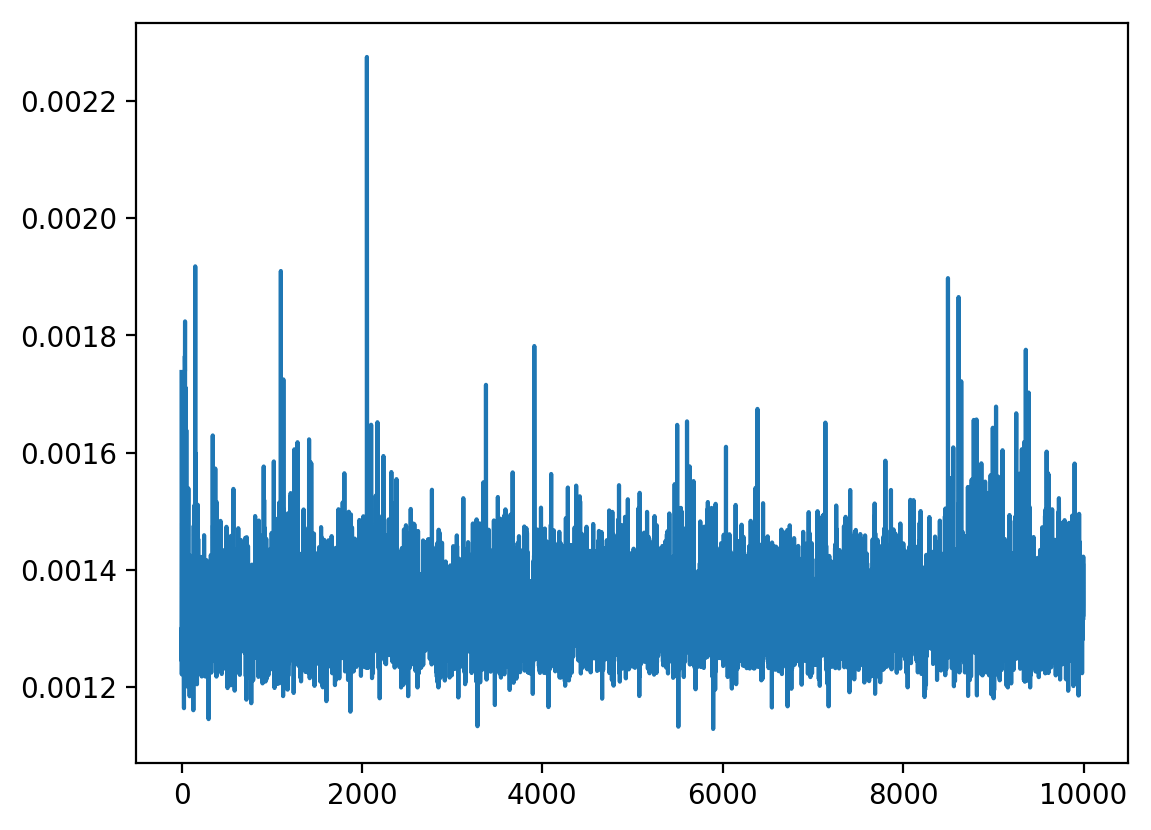

In [74]:
data = {'time': np.zeros((10000,1)), 'pos': np.zeros((10000,1))}

t0 = time.monotonic() # relative time
s0 = m1.encoder.pll_pos # relative position

for kk in range(0,10000):
    setpoint = 20000.0 * math.sin((time.monotonic() - t0)*2) + s0
    m1.set_pos_setpoint(setpoint, 0.0, 0.0)
    
    data['time'][kk] = time.monotonic()
    data['pos'][kk] = m1.encoder.pll_pos

# stop and set position to hold at current pos
my_drive.motor1.set_vel_setpoint(0,0.)
my_drive.motor1.set_pos_setpoint(my_drive.motor1.encoder.pll_pos,0., 0.)

plt.plot(np.diff(data['time'],1,0))

print('Mean transfer rate: %f Hz' % np.mean(1/np.diff(data['time'],1,0)))
print('Stddev transfer rate: %f Hz' % np.std(1/np.diff(data['time'],1,0)))

plt.gcf()


In [ ]:
my_drive.motor1.set_pos_setpoint(setpoint, 0.0, 0.0)

## Step displacement testing

Motor step displacement

In [107]:
data = {'time': np.zeros((10000,1)), 
        'pos': np.zeros((10000,1)), 
        'commanded': np.zeros((10000,1))}

t0 = time.monotonic() # relative time
s0 = m1.encoder.pll_pos # relative position
setpoint = 0;

for kk in range(0,10000):
    if kk == 1000:
            setpoint = (4*encoder_resolution)/10
            m1.set_pos_setpoint(s0 + setpoint, 0.0, 0.0)

    data['time'][kk] = time.monotonic() - t0
    data['pos'][kk] = m1.encoder.pll_pos - s0
    data['commanded'][kk] = setpoint

# stop and set position to hold at current pos
my_drive.motor1.set_vel_setpoint(0,0.)
my_drive.motor1.set_pos_setpoint(my_drive.motor1.encoder.pll_pos,0., 0.)

plt.clf()
plt.plot(data['time'], data['pos'])
plt.plot(data['time'], data['commanded'])

plt.xlabel('Time (s)')
plt.ylabel('Encoder position')

